In [16]:
import os
import shutil
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import nibabel as nib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init



## Dataset Classes

In [3]:
# Only the MRI scans
class ICHDataset:
    def __init__(self, data_root_folder, folder = ''):
        self.folder_path = os.path.join(data_root_folder, folder)

    def __getitem__(self, index):
        file_name = os.listdir(self.folder_path)[index]
        img = nib.load(os.path.join(self.folder_path, file_name)).get_fdata()
        img_as_tensor = torch.from_numpy(img)
        
        return {
            'image': img_as_tensor.type(torch.FloatTensor),
            'img_id': file_name
        }
 
    def __len__(self):
        return len(os.listdir(self.folder_path))

path = r'C:\Users\lisag\OneDrive\Bureau\Columbia_Coursework\Spring_2023\DLBI\ICH\data'
dataset = ICHDataset(path, folder = 'img_train_val_test')
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=2)

torch.Size([512, 512, 32])


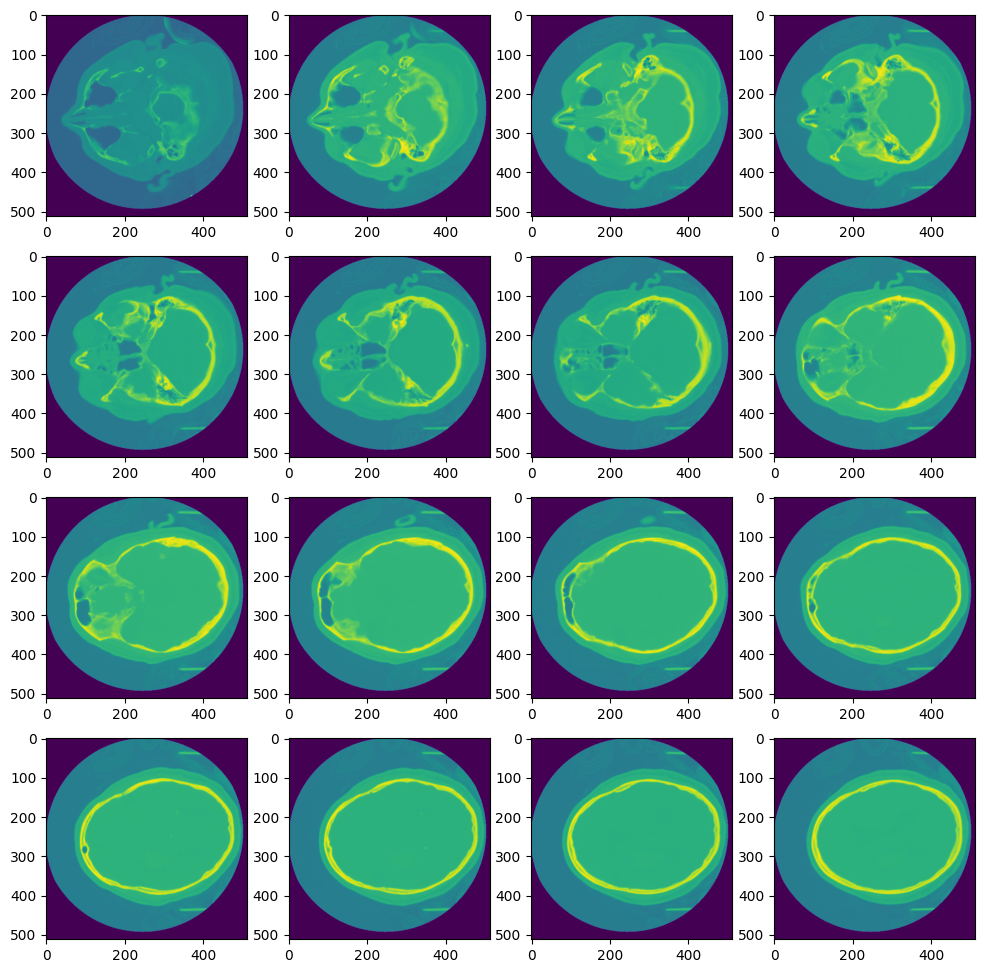

In [4]:
# plotting 32 slices of one MRI scan (512x512 dim of slices)
sample = np.random.randint(0, len(dataset))
data = dataset.__getitem__(sample)
x = data['image']
print(x.shape) # 512x512x32 
plt.style.use('default')
fig, axes = plt.subplots(4,4, figsize=(12,12))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(x[:,:,1 + i])
plt.show()

In [5]:
# Loading MRI and masks from training and validation sets
class SliceDataset:
    def __init__(self, img_pathes: Path, mask_pathes: Path, intensity_min, intensity_max) -> None:
        self.img_pathes = img_pathes
        self.mask_pathes = mask_pathes
        self.slices = [nib.load(p).shape[-1] for p in self.img_pathes] #img_pathes are all the nii.gz files, 
        #p is one nii.gz file of size [512x512xnb_slices] and we are counting the number of slices for each nii.gz file
        self.cum_slices = np.cumsum(self.slices) # doing cumulative sum on the number of slices
        self.intensity_min = intensity_min
        self.intensity_max = intensity_max

    def __getitem__(self, index: int): # index : slice number
        path_index = np.searchsorted(self.cum_slices, index, side='right') #returns the patient number
        if path_index == 0:
            slice_index = index
        else:
            slice_index = index - self.cum_slices[path_index - 1] #returns the slice index for a given patient

        img = nib.load(self.img_pathes[path_index]).get_fdata()[:,:,slice_index] #gets the image of wanted slice
        img = windowing(img, self.intensity_min, self.intensity_max)[np.newaxis, ...] # minmax scaler + add one dimension: (1, 512, 512)
        mask = np.load(self.mask_pathes[path_index])[:,:,slice_index][np.newaxis, ...] #gets the mask of wanted slice + add one dimension: (1, 512, 512)
        return img.astype(np.float32), mask.astype(np.float32)
    
    def __len__(self):
        return self.cum_slices[-1]
    
def windowing(image, min_value, max_value):
    image_new = np.clip(image, min_value, max_value)
    image_new = (image_new - min_value) / (max_value - min_value)
    return image_new


In [6]:
img_train_val_test = Path(r'C:\Users\lisag\OneDrive\Bureau\Columbia_Coursework\Spring_2023\DLBI\ICH\data\img_train_val_test') # WindowsPath of mri scans folder
mask_train_val_pathes = sorted(Path(r"C:\Users\lisag\OneDrive\Bureau\Columbia_Coursework\Spring_2023\DLBI\ICH\data\mask_train_val").glob('*.npy')) # WindowsPath of all masks
img_train_val_pathes = [img_train_val_test / p.name.replace('.npy', '.nii.gz') for p in mask_train_val_pathes] # WindowsPath of all mri scans using the same order as the masks
print(f'len(img_train_val_pathes) = {len(img_train_val_pathes)}')
print(f'len(mask_train_val_pathes) = {len(mask_train_val_pathes)}')
train_size = 0.9
random_seed = 230620
img_train_pathes, img_val_pathes, mask_train_pathes, mask_val_pathes = train_test_split(
    img_train_val_pathes, mask_train_val_pathes, train_size=train_size, random_state=random_seed
)
print(f'len(img_train_pathes) = {len(img_train_pathes)}')
print(f'len(img_val_pathes) = {len(img_val_pathes)}')
print(f'len(mask_train_pathes) = {len(mask_train_pathes)}')
print(f'len(mask_val_pathes) = {len(mask_val_pathes)}')
intensity_min = 30
intensity_max = 100

len(img_train_val_pathes) = 230
len(mask_train_val_pathes) = 230
len(img_train_pathes) = 207
len(img_val_pathes) = 23
len(mask_train_pathes) = 207
len(mask_val_pathes) = 23


torch.Size([1, 1, 512, 512])
torch.Size([1, 1, 512, 512])


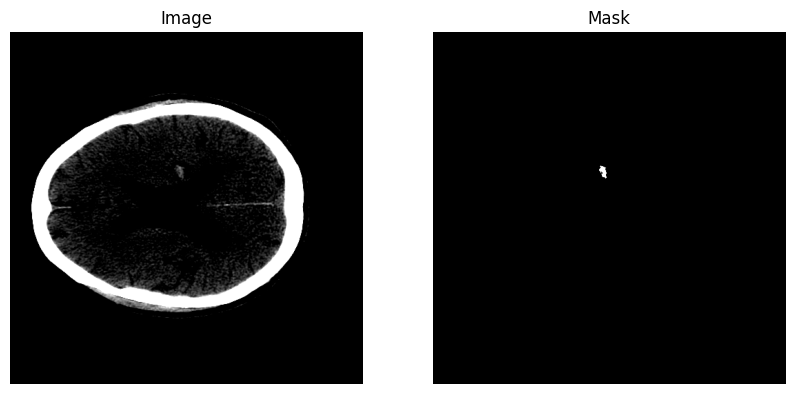

In [11]:
trainset = SliceDataset(img_train_pathes, mask_train_pathes, intensity_min, intensity_max)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=0)

# plotting img and mask side by side
data = next(iter(trainloader))
img = data[0]
mask = data[1]
print(img.shape) # 1x1x512x512 [1 slice x batch x height x width]
print(mask.shape) # 1x1x512x512 [1 slice x batch x height x width]


def plot_img_mask(img, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot image
    axs[0].imshow(img.squeeze(), cmap='gray')
    axs[0].set_title('Image')
    axs[0].axis('off')

    # Plot mask
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Assuming you have loaded `img` and `mask` from the trainloader
plot_img_mask(img[0][0], mask[0][0])


In [12]:
class VolumeDataset:
    def __init__(self, img_pathes: Path, mask_pathes: Path, intensity_min, intensity_max) -> None:
        self.img_pathes = img_pathes
        self.mask_pathes = mask_pathes
        self.intensity_min = intensity_min
        self.intensity_max = intensity_max

    def __getitem__(self, index: int):
        path_index = index #indice of patient

        img = nib.load(self.img_pathes[path_index]).get_fdata() #[512, 512, 32]
        img = np.transpose(img, (2,0,1)) # [32, 512, 512]
        img = windowing(img, self.intensity_min, self.intensity_max)[:, np.newaxis, ...] # [32, 1, 512, 512]
        mask = np.load(self.mask_pathes[path_index])
        mask = np.transpose(mask, (2,0,1))[:, np.newaxis, ...] # [32, 1, 512, 512]
        return img.astype(np.float32), mask.astype(np.float32), path_index
    
    def __len__(self):
        return len(self.img_pathes)

valset = VolumeDataset(img_val_pathes, mask_val_pathes, intensity_min, intensity_max)
valloader = DataLoader(valset, batch_size=None, shuffle=True, num_workers=0)

torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512])


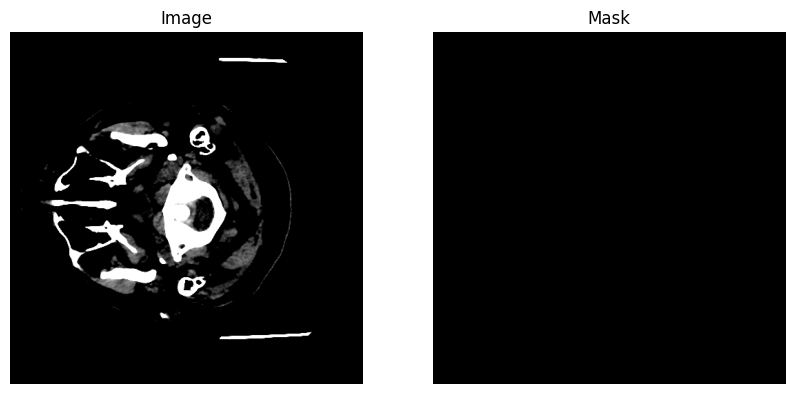

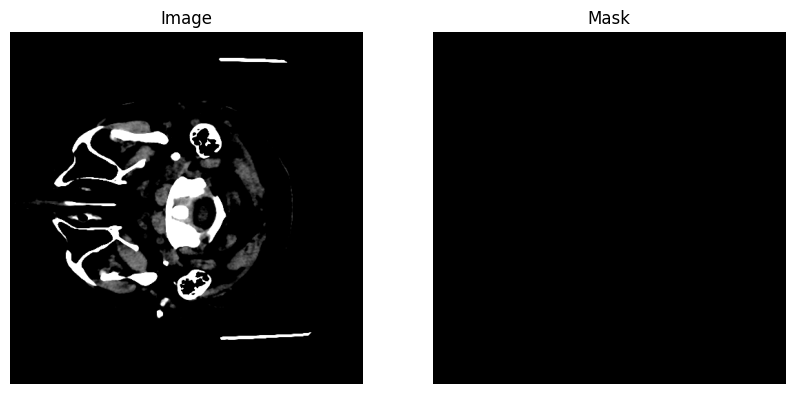

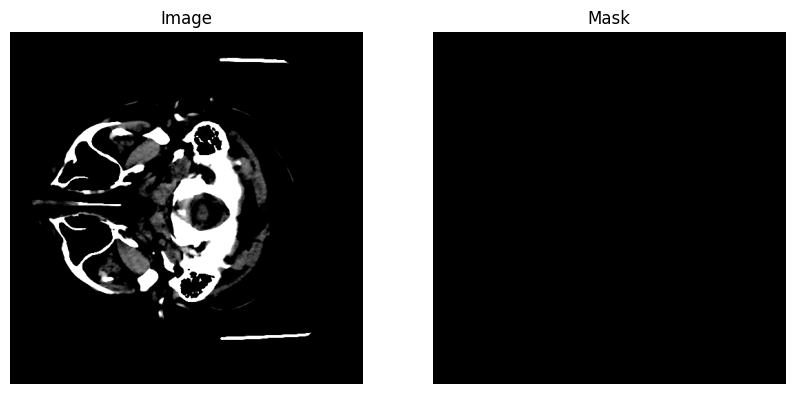

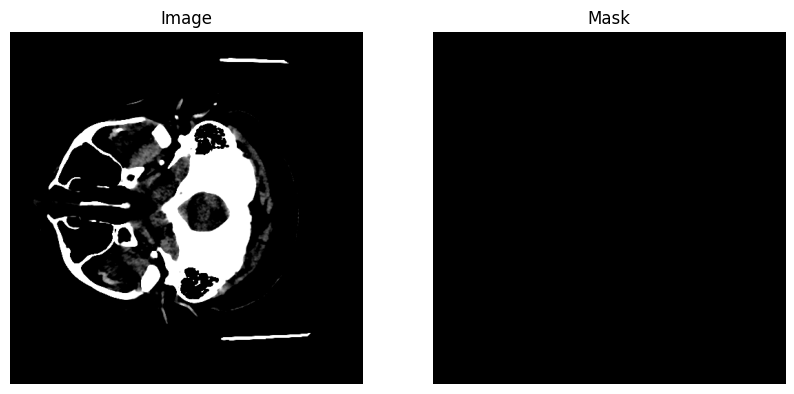

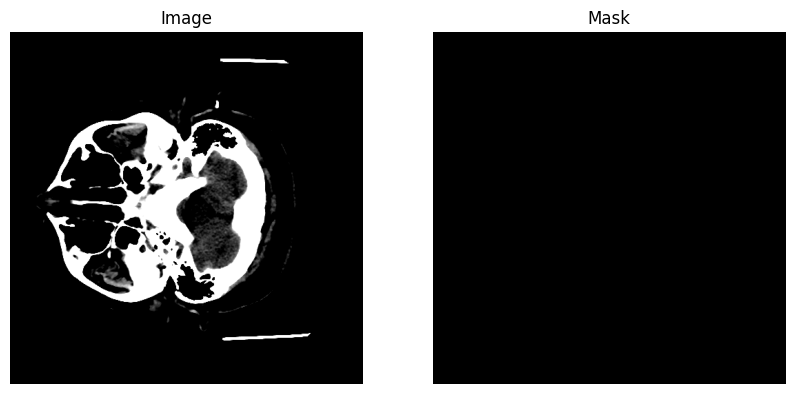

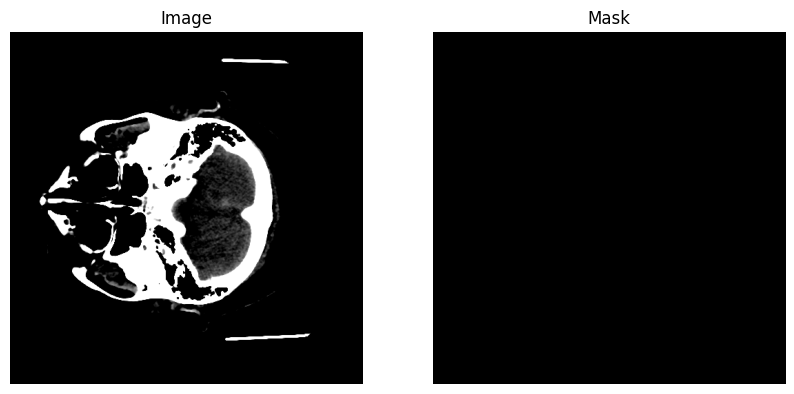

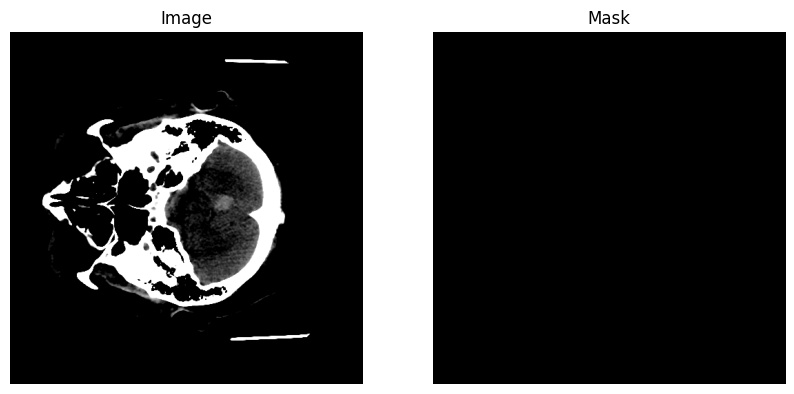

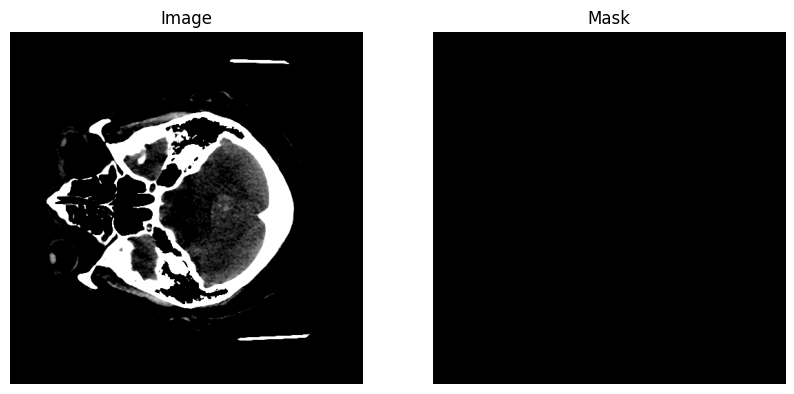

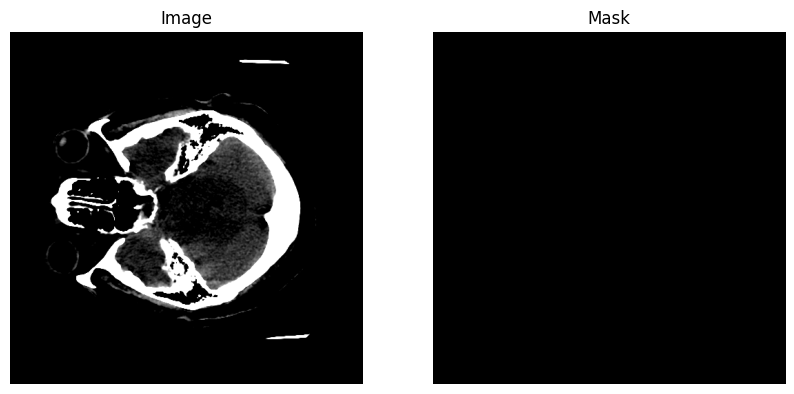

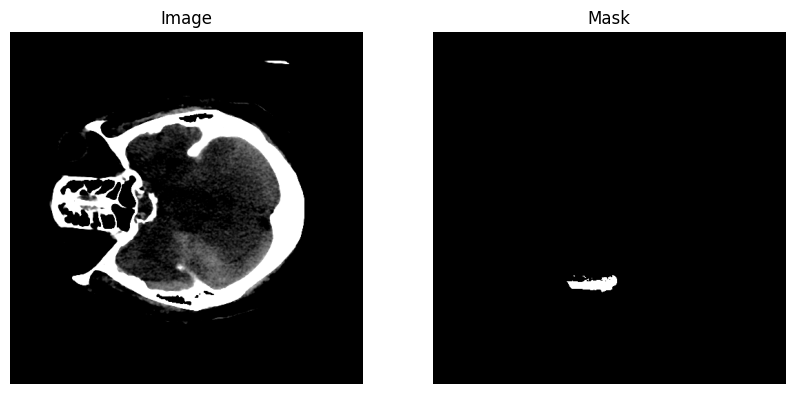

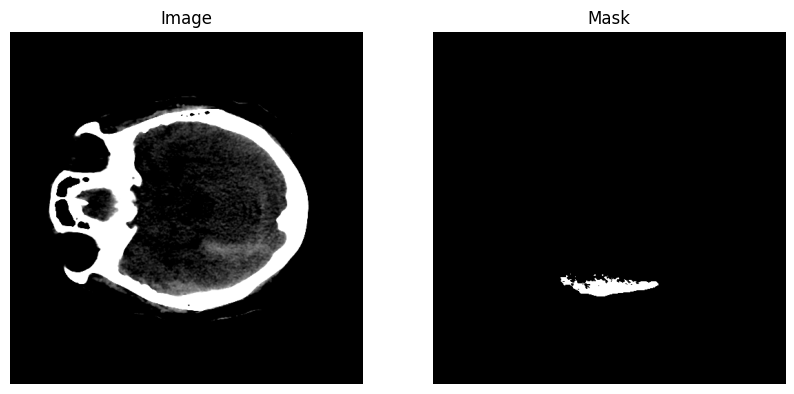

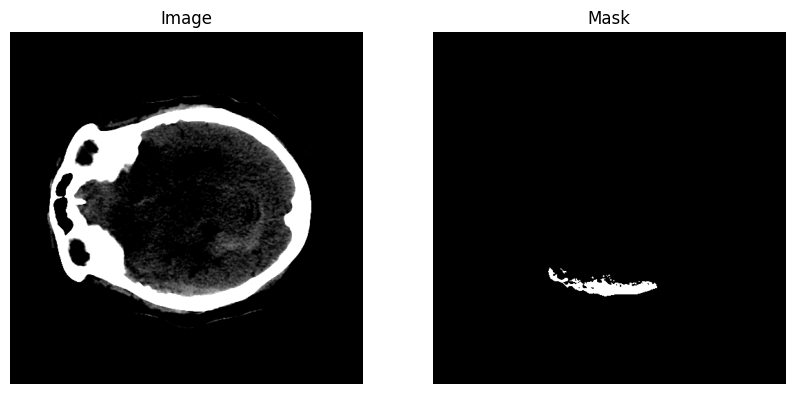

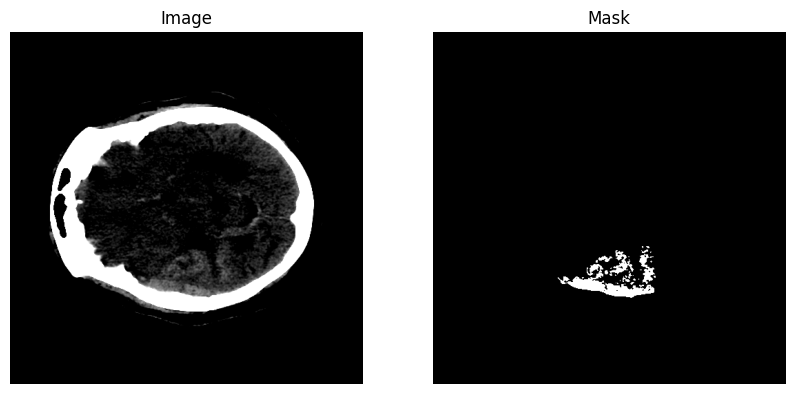

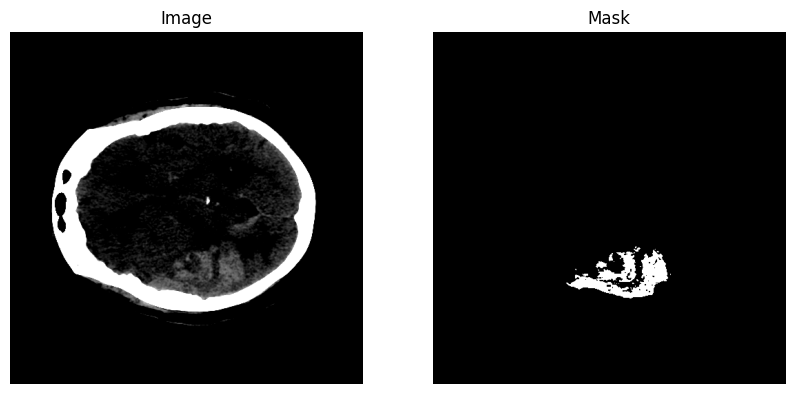

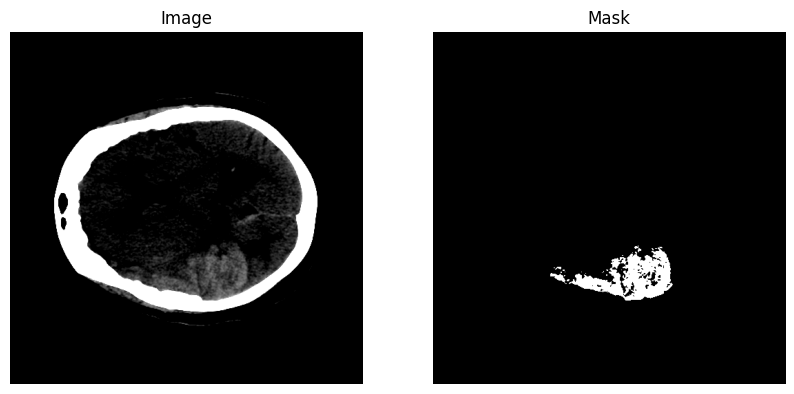

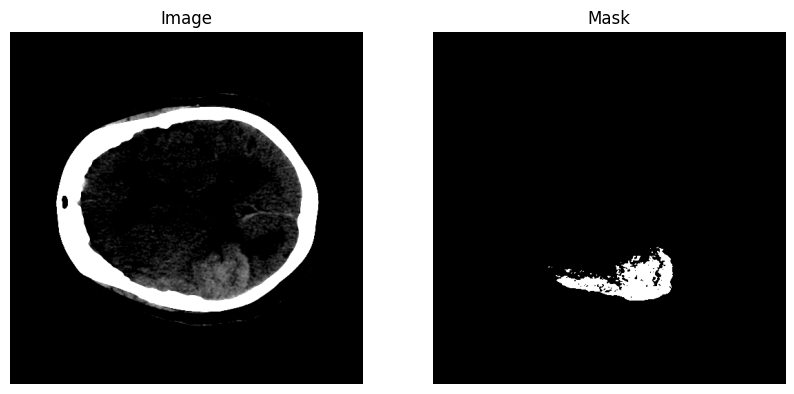

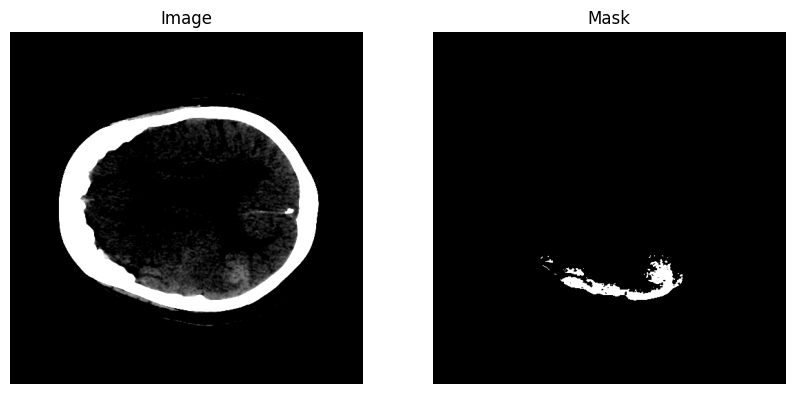

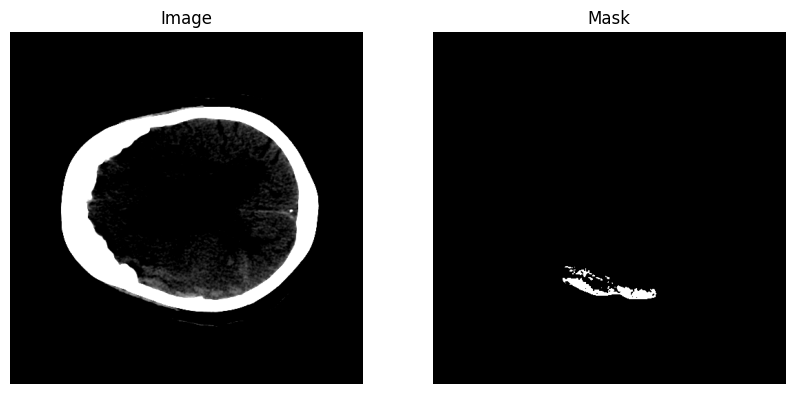

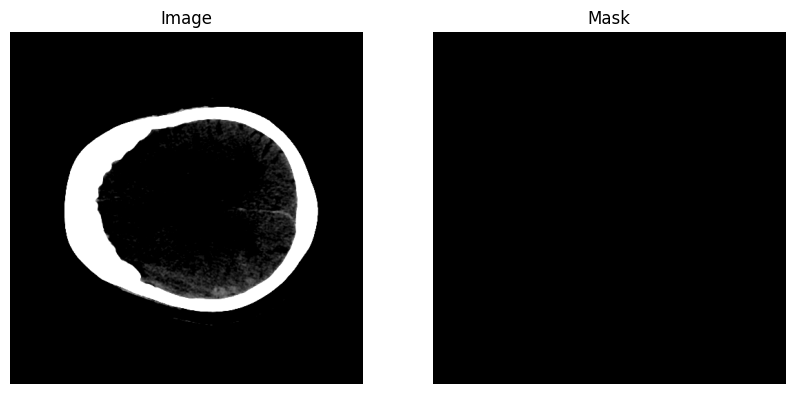

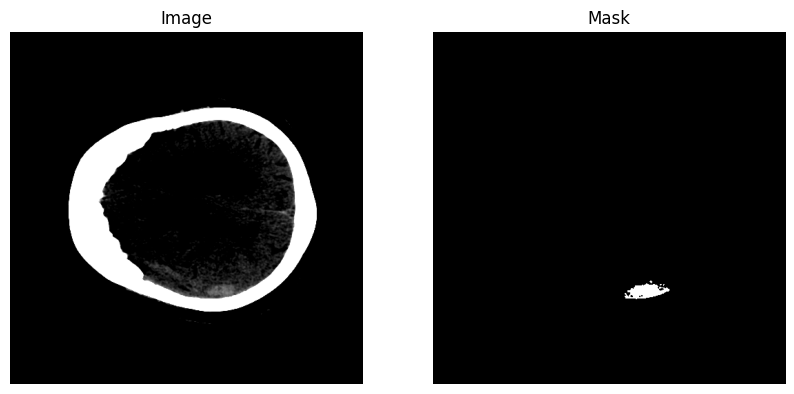

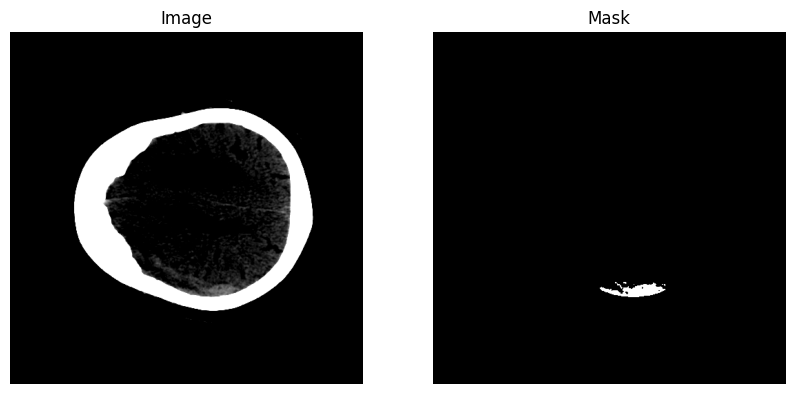

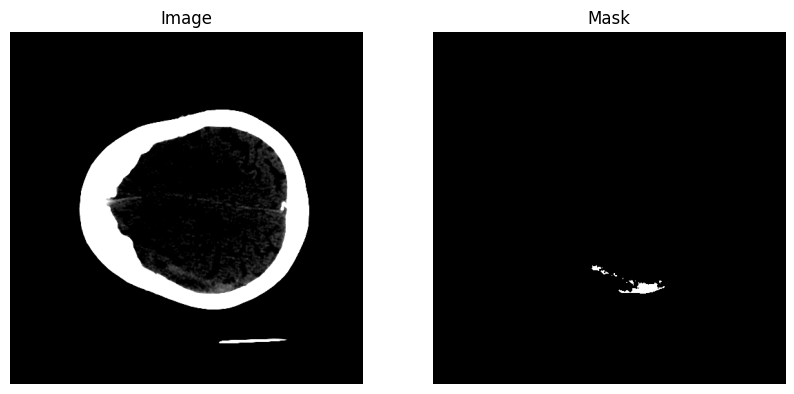

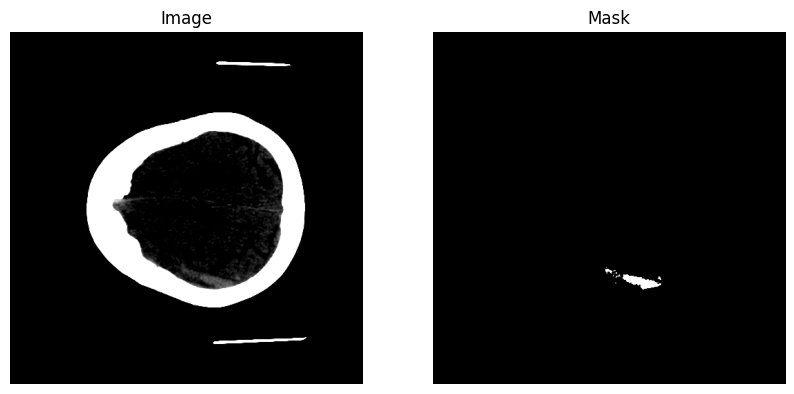

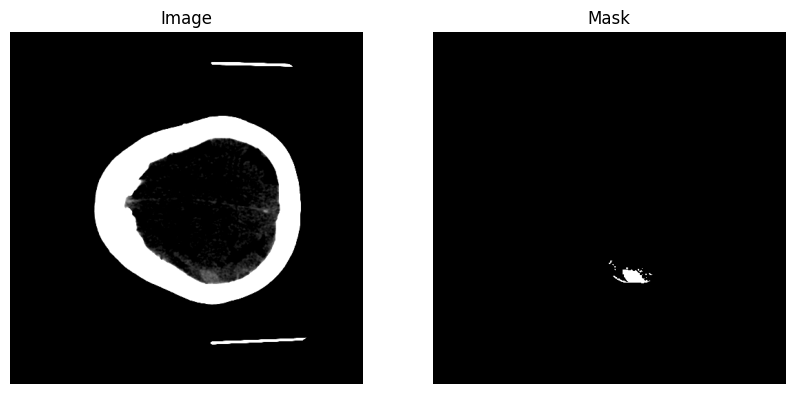

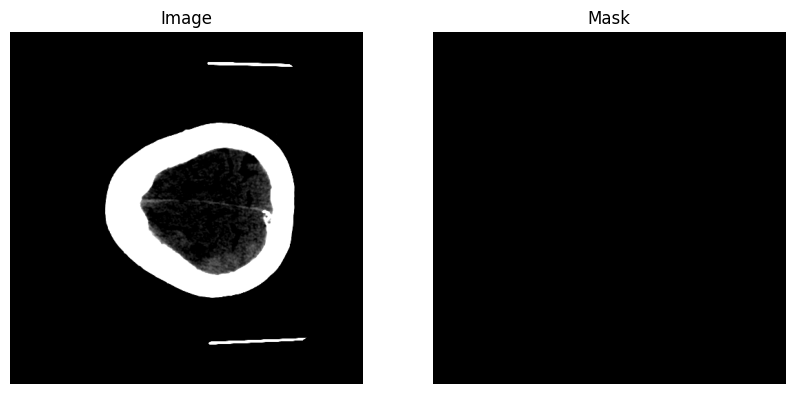

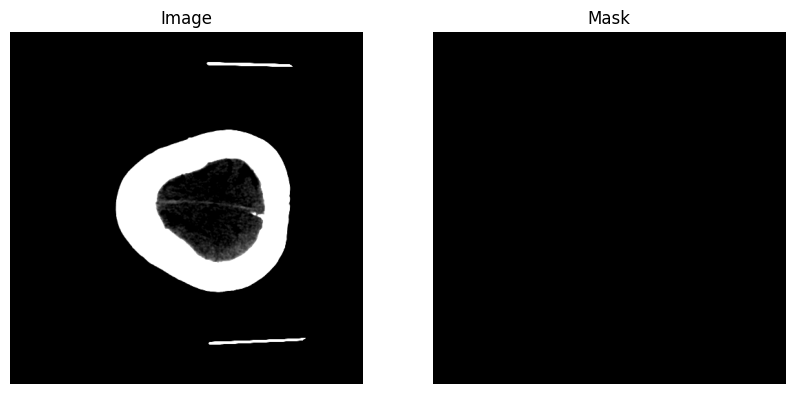

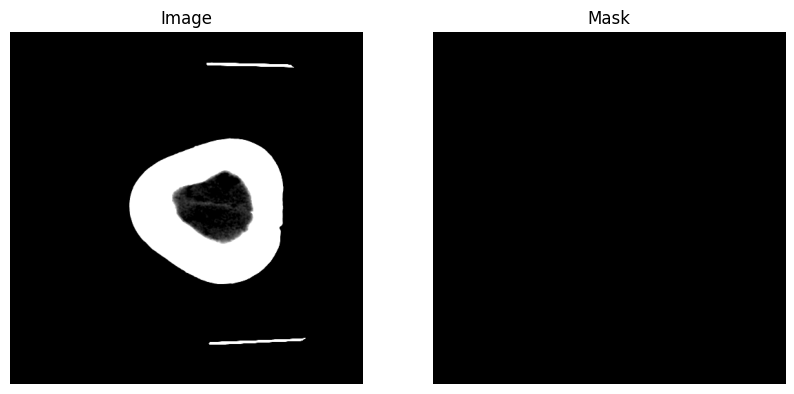

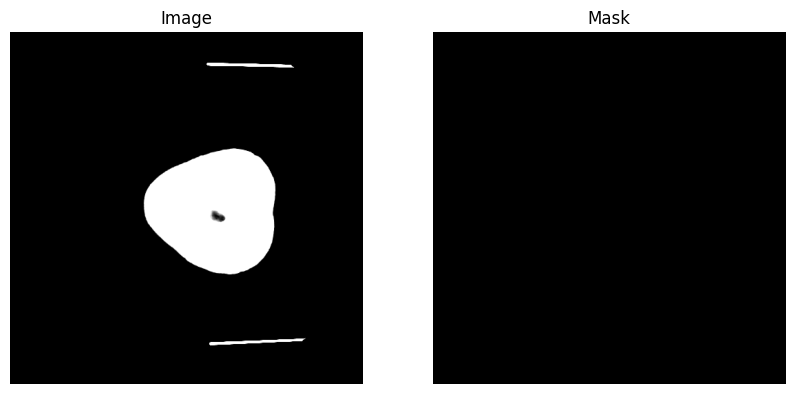

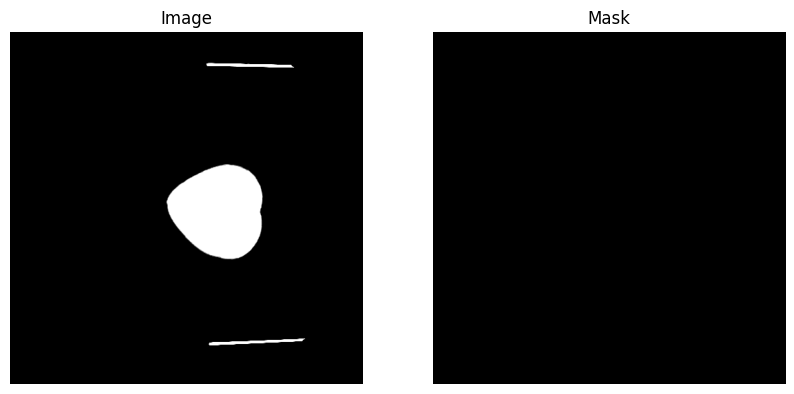

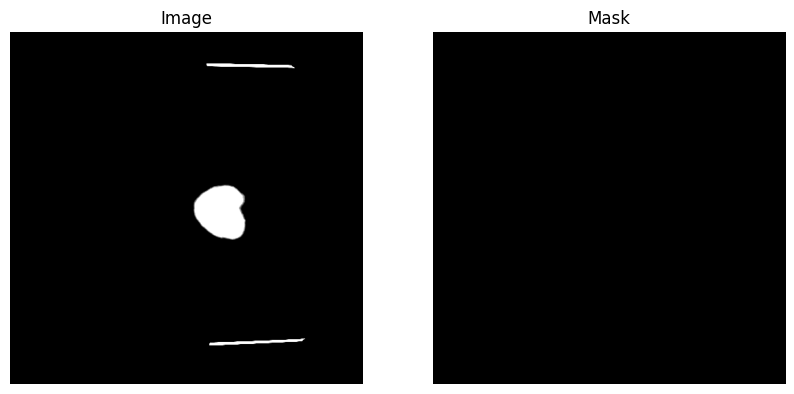

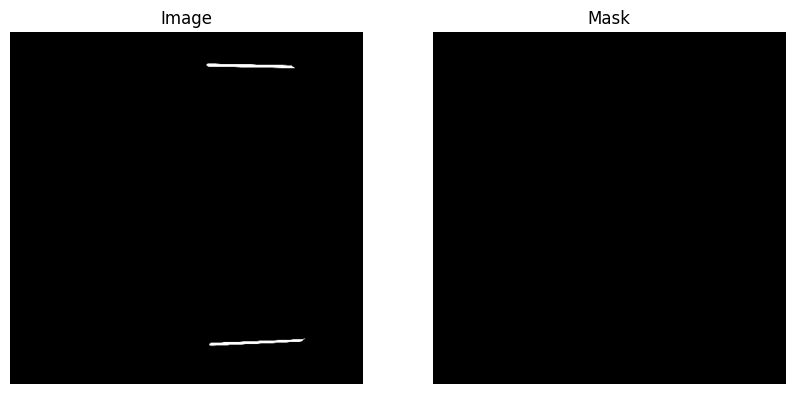

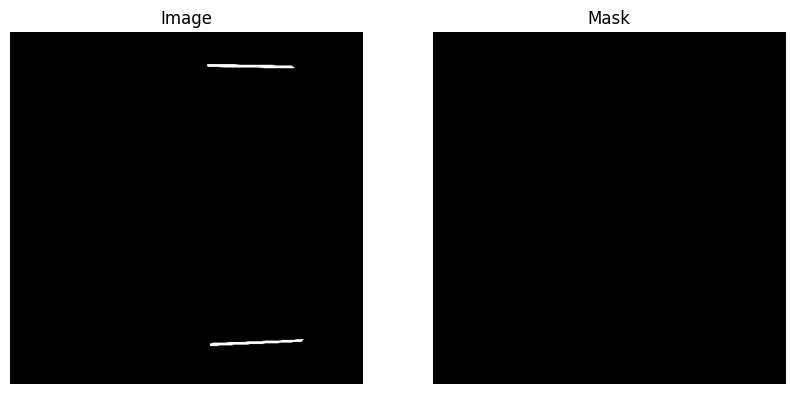

In [15]:
# plotting img and mask side by side
# Note: some patients have different number of slices, maximum is 64
data = next(iter(valloader))
img = data[0]
mask = data[1]
print(img.shape) # nb_slicesx1x512x512  [nbslices x batch x height x width]
print(mask.shape) # nb_slicesx1x512x512  [nbslices x batch x height x width]

# Assuming you have loaded `img` and `mask` from the trainloader
for i in range(img.shape[0]):
    plot_img_mask(img[i][0], mask[i][0])

## U-Net Model

In [17]:
class conv_block(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(conv_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(32, ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(32, ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.GroupNorm(32, ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x



class U_Net(nn.Module):
    def __init__(self, img_ch=3, output_ch=1, first_layer_numKernel=64):
        super(U_Net, self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(ch_in=img_ch, ch_out=first_layer_numKernel)
        self.Conv2 = conv_block(ch_in=first_layer_numKernel, ch_out=2 * first_layer_numKernel)
        self.Conv3 = conv_block(ch_in=2 * first_layer_numKernel, ch_out=4 * first_layer_numKernel)
        self.Conv4 = conv_block(ch_in=4 * first_layer_numKernel, ch_out=8 * first_layer_numKernel)
        self.Conv5 = conv_block(ch_in=8 * first_layer_numKernel, ch_out=16 * first_layer_numKernel)

        self.Up5 = up_conv(ch_in=16 * first_layer_numKernel, ch_out=8 * first_layer_numKernel)
        self.Up_conv5 = conv_block(ch_in=16 * first_layer_numKernel, ch_out=8 * first_layer_numKernel)

        self.Up4 = up_conv(ch_in=8 * first_layer_numKernel, ch_out=4 * first_layer_numKernel)
        self.Up_conv4 = conv_block(ch_in=8 * first_layer_numKernel, ch_out=4 * first_layer_numKernel)

        self.Up3 = up_conv(ch_in=4 * first_layer_numKernel, ch_out=2 * first_layer_numKernel)
        self.Up_conv3 = conv_block(ch_in=4 * first_layer_numKernel, ch_out=2 * first_layer_numKernel)

        self.Up2 = up_conv(ch_in=2 * first_layer_numKernel, ch_out=first_layer_numKernel)
        self.Up_conv2 = conv_block(ch_in=2 * first_layer_numKernel, ch_out=first_layer_numKernel)

        self.Conv_1x1 = nn.Sequential(
            nn.Conv2d(first_layer_numKernel, output_ch, kernel_size=1, stride=1, padding=0), nn.Sigmoid()  # Use sigmoid activation for binary segmentation
        )
        # self.Conv_1x1 =  nn.Conv2d(first_layer_numKernel, output_ch, kernel_size = 1, stride = 1, padding = 0)

    def forward(self, x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5), dim=1)

        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1





In [ ]:
def dice_coeff_binary(y_pred, y_true):
        """Values must be only zero or one."""
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        eps = 0.0001
        inter = torch.dot(y_pred.view(-1).float(), y_true.view(-1).float())
        union = torch.sum(y_pred.float()) + torch.sum(y_true.float())
        return ((2 * inter.float() + eps) / (union.float() + eps))

In [ ]:
def train_unet():
    

In [ ]:
class train_unet():
    def __init__(self, net, lr, loss, jaccard, batch_size):
        super().__init__()
        self.net = net
        self.lr = lr
        self.loss = loss 
        self.jaccard = jaccard
        self.sigmoid = nn.Sigmoid()
        self.batch_size = batch_size
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        imgs = batch['image']
        true_masks = batch['mask']#.squeeze(1)
        y_pred = self(imgs)  
        loss = self.loss(y_pred.squeeze(1), true_masks.squeeze(1))
        
        #y_pred = (y_pred >= 0.5).float()
        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.unsqueeze(1)

    
        batch_dice_score = dice_coeff_binary(y_pred, true_masks)
        batch_jaccard_score = jaccard_index_metric(y_pred, true_masks)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)
        self.log("train_dice", batch_dice_score, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)
        self.log("train_jaccard", batch_jaccard_score, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)

        return loss
    
    def validation_step(self, batch, batch_idx):
        imgs = batch['image']
        true_masks = batch['mask']#.squeeze(1)
        
        y_pred = self(imgs)
        #y_pred = (y_pred >= 0.5).float()
        loss = self.loss(y_pred.squeeze(1), true_masks.squeeze(1))

        y_pred = torch.argmax(y_pred, dim=1)
        y_pred = y_pred.unsqueeze(1)

        batch_dice_score = dice_coeff_binary(y_pred, true_masks)
        batch_jaccard_score = jaccard_index_metric(y_pred, true_masks)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)
        self.log("val_dice", batch_dice_score, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)
        self.log("val_jaccard", batch_dice_score, on_step=False, on_epoch=True, prog_bar=True, logger=True, sync_dist=True, batch_size=self.batch_size)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = CosineAnnealingLR(optimizer, self.trainer.max_epochs * 200, 0)
        return [optimizer], [scheduler]